[Sebastian Raschka](http://sebastianraschka.com), 2016

https://github.com/rasbt/python-machine-learning-book

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -d -p scikit-learn,numpy,scipy

Sebastian Raschka 2016-03-23 

CPython 3.5.1
IPython 4.0.3

scikit-learn 0.17.1
numpy 1.10.4
scipy 0.17.0


In [2]:
# to install watermark just uncomment the following line:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py

# Scikit-learn Model Persistence using JSON

In many situations, it is desirable to store away a trained model for future use. These situations where we want to persist a model could be the deployment of a model in a web application, for example, or scientific reproducibility of our experiments.

I [wrote](http://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/ch09/ch09.ipynb#Serializing-fitted-scikit-learn-estimators) a little bit about serializing scikit-learn models using `pickle` in context of the web applications that we developed in chapter 8. Also, you can find an excellent [tutorial section](http://scikit-learn.org/stable/modules/model_persistence.html) on scikit-learn's website. Honestly, I would say that pickling Python objects via the [`pickle`](https://docs.python.org/3.5/library/pickle.html), [`dill`](https://pypi.python.org/pypi/dill) or [`joblib`](https://pythonhosted.org/joblib/) modules is probably the most convenient approach to model persistence. However, pickling Python objects can sometimes be a little bit problematic, for example, deserializing a model in Python 3.x that was originally pickled in Python 2.7x and vice versa. Also, pickle offers different protocols (currently the protocols `0-4`), which are not necessarily backwards compatible. 
Thus, to prepare for the worst case scenario -- corrupted pickle files or version incompatibilities -- there's at least one other (a little bit more tedious) way to model persistence using [JSON](http://www.json.org). 

> JSON (JavaScript Object Notation) is a lightweight data-interchange format. It is easy for humans to read and write. It is easy for machines to parse and generate. It is based on a subset of the JavaScript Programming Language, Standard ECMA-262 3rd Edition - December 1999. JSON is a text format that is completely language independent but uses conventions that are familiar to programmers of the C-family of languages, including C, C++, C#, Java, JavaScript, Perl, Python, and many others. These properties make JSON an ideal data-interchange language. [Source: http://www.json.org]

One of the advantages of JSON is that it is a human-readable format. So, if push comes to shove, we should still be able to read the parameter files and model coefficients "manually" and assign these values to the respective scikit-learn estimator or build our own model to reproduce scientific results.

Let's see how that works ... First, let us train a simple logistic regression classifier on Iris:

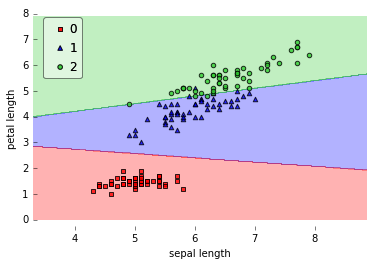

In [3]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression 
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from mlxtend.evaluate import plot_decision_regions

iris = load_iris()
y, X = iris.target, iris.data[:, [0, 2]]  # only use 2 features
lr = LogisticRegression(C=100.0, 
                        class_weight=None, 
                        dual=False, 
                        fit_intercept=True,
                        intercept_scaling=1, 
                        max_iter=100, 
                        multi_class='multinomial', 
                        n_jobs=1,
                        penalty='l2', 
                        random_state=1, 
                        solver='newton-cg', 
                        tol=0.0001,
                        verbose=0, 
                        warm_start=False)
lr.fit(X, y)
plot_decision_regions(X=X, y=y, clf=lr, legend=2)
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.show()

Luckily, we don't have to retype or copy & paste all the estimator parameters manually if we want to store them away. To get a dictionary of these parameters, we can simply use the handy "get_params" method:

In [4]:
lr.get_params()

{'C': 100.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Storing them in JSON format is easy, we simply import the `json` module from Python's standard library and dump the dictionary to a file:

In [5]:
import json

with open('./sckit-model-to-json/params.json', 'w', encoding='utf-8') as outfile:
   json.dump(lr.get_params(), outfile)

When we read the file, we can see that the JSON file is just a 1-to-1 copy of our Python dictionary in text format:

In [6]:
with open('./sckit-model-to-json/params.json', 'r', encoding='utf-8') as infile:
    print(infile.read())

{"dual": false, "max_iter": 100, "warm_start": false, "verbose": 0, "C": 100.0, "class_weight": null, "random_state": 1, "fit_intercept": true, "multi_class": "multinomial", "intercept_scaling": 1, "penalty": "l2", "solver": "newton-cg", "n_jobs": 1, "tol": 0.0001}


Now, the trickier part is to identify the "fit" parameters of the estimator, i.e., the parameters of our logistic regression model. However, in practice it's actually pretty straight forward to figure it out by heading over to the respective [documentation page](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): Just look out for the "attributes" in the "Attribute" section that have a trailing underscore (thanks, scikit-learn team, for the beautifully thought-out API!). In case of logistic regression, we are interested in the weights `.coef_`, the bias unit `.intercept_`, and the `classes_` and `n_iter_` attributes.

In [7]:
attrs = [i for i in dir(lr) if i.endswith('_') and not i.endswith('__')]
print(attrs)

['classes_', 'coef_', 'intercept_', 'n_iter_']


In [8]:
attr_dict = {i: getattr(lr, i) for i in attrs}

In order to deserialize NumPy arrays to JSON objects, we need to cast the arrays to (nested) Python lists first, however, it's not that much of a hassle thanks to the `tolist` method. (Also, consider saving the attributes to separate JSON files, e.g., intercept.json and coef.json, for clarity.)

In [9]:
import numpy as np

for k in attr_dict:
    if isinstance(attr_dict[k], np.ndarray):
        attr_dict[k] = attr_dict[k].tolist()

Now, we are ready to dump our "attribute dictionary" to a JSON file:

In [10]:
with open('./sckit-model-to-json/attributes.json', 'w', encoding='utf-8') as outfile:    
   json.dump(attr_dict, 
             outfile, 
             separators=(',', ':'), 
             sort_keys=True, 
             indent=4)

If everything went fine, our JSON file should look like this -- in plaintext format:

In [11]:
with open('./sckit-model-to-json/attributes.json', 'r', encoding='utf-8') as infile:
    print(infile.read())

{
    "classes_":[
        0,
        1,
        2
    ],
    "coef_":[
        [
            0.42625236403173844,
            -8.557501546363858
        ],
        [
            1.5644231337040186,
            -1.6783659020502222
        ],
        [
            -1.990675497337773,
            10.235867448186507
        ]
    ],
    "intercept_":[
        27.533384852155145,
        4.18509910962595,
        -31.71848396177913
    ],
    "n_iter_":[
        27
    ]
}


With similar ease, we can now use `json`'s `loads` method to read the data back from the ".json" files and re-assign them to Python objects. (Imagine the following happens in a new Python session.)

In [12]:
import codecs
import json

obj_text = codecs.open('./sckit-model-to-json/params.json', 'r', encoding='utf-8').read()
params = json.loads(obj_text)

obj_text = codecs.open('./sckit-model-to-json/attributes.json', 'r', encoding='utf-8').read()
attributes = json.loads(obj_text)

Finally, we just need to initialize a default `LogisticRegression` estimator, feed it the desired parameters via the `set_params` method, and reassign the other attributes using Python's built-in `setattr` (don't forget to recast the Python lists to NumPy arrays, though!):

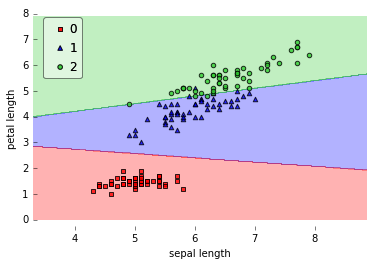

In [13]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression 
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from mlxtend.evaluate import plot_decision_regions
import numpy as np

iris = load_iris()
y, X = iris.target, iris.data[:, [0, 2]]  # only use 2 features
lr = LogisticRegression()

lr.set_params(**params)
for k in attributes:
    if isinstance(attributes[k], list):
        setattr(lr, k, np.array(attributes[k]))
    else:
        setattr(lr, k, attributes[k])


plot_decision_regions(X=X, y=y, clf=lr, legend=2)
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.show()